### We use a deliberately simple and widely used technical trading rule as an example to isolate the effect of stop-loss design.

The strategy goes long the S&P 500 when the price crosses above its moving average and exits either on a moving-average breakdown or a fixed percentage stop-loss.
By holding the signal generation constant, this framework allows us to cleanly evaluate how different stop-loss levels affect win rate, payoff ratio, and long-run performance.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

FILE_PATH = "/Users/charlesxiong/Desktop/IBKR_algo/ode/data/SPX/SPX_DT.xlsx"

# ====== Parameters ======
MA_WINDOW = 30
STOP_LEVELS = np.linspace(0.005, 0.1, 100)  # evenly spaced
EXIT_ON_CLOSE_BELOW_MA = True               # If you don't want MA-based exit, set to False

OUT_PREFIX = "cross20_longonly_stop_sweep"

OPEN_COL, HIGH_COL, LOW_COL, CLOSE_COL = "SPXopen", "SPXhigh", "SPXlow", "SPXclose"

# ====== Load data ======
df = pd.read_excel(FILE_PATH)
df["DateTime"] = pd.to_datetime(df["DateTime"])
df = df.sort_values("DateTime").reset_index(drop=True)
df = df[df.DateTime.dt.year >= 2000]
df["MA20"] = df[CLOSE_COL].rolling(MA_WINDOW, min_periods=MA_WINDOW).mean()

# Entry signal:
# Yesterday crossed above MA
# (t-2 below MA, t-1 above MA) => enter long today (t)
# entry_signal[t] = 1 means "enter long on day t"
c = df[CLOSE_COL]
ma = df["MA20"]
df["entry_signal"] = ((c.shift(2) <= ma.shift(2)) & (c.shift(1) > ma.shift(1))).astype(int)

# Exit signal (optional):
# Yesterday's close fell back below MA => no position today
df["exit_signal"] = ((c.shift(1) < ma.shift(1))).astype(int)

# Drop periods before MA is fully formed
df = df.dropna(subset=["MA20"]).reset_index(drop=True)

def backtest_one_stop(stop: float):
    o = df[OPEN_COL].to_numpy()
    h = df[HIGH_COL].to_numpy()
    l = df[LOW_COL].to_numpy()
    c = df[CLOSE_COL].to_numpy()
    entry_sig = df["entry_signal"].to_numpy()
    exit_sig = df["exit_signal"].to_numpy()

    daily_ret = np.zeros(len(df), dtype=float)

    in_pos = False
    entry_ref = np.nan         # Stop-loss reference: previous day's close (entry reference price)
    trade_ret_mul = 1.0
    trades = []

    for t in range(1, len(df)):
        # First decide whether we should still hold the position today
        # (signals are generated yesterday and executed today)
        if in_pos and EXIT_ON_CLOSE_BELOW_MA and exit_sig[t] == 1:
            # Exit before today's open
            # (equivalent to deciding at yesterday's close not to hold today)
            trades.append(trade_ret_mul - 1.0)
            in_pos = False
            entry_ref = np.nan
            trade_ret_mul = 1.0

        # If no position, check whether to enter today
        if (not in_pos) and entry_sig[t] == 1:
            in_pos = True
            entry_ref = c[t-1]   # As defined: stop is based on previous day's close
            trade_ret_mul = 1.0

        if not in_pos:
            daily_ret[t] = 0.0
            continue

        # If in position: check stop-loss first (based on entry_ref)
        stop_price = entry_ref * (1.0 - stop)

        # More realistic execution:
        # If price gaps below stop at open, exit at open;
        # otherwise, if stop is hit intraday, exit at stop price
        if o[t] <= stop_price:
            exit_px = o[t]
            daily_ret[t] = (exit_px / c[t-1]) - 1.0
            trade_ret_mul *= (1.0 + daily_ret[t])
            trades.append(trade_ret_mul - 1.0)

            in_pos = False
            entry_ref = np.nan
            trade_ret_mul = 1.0
            continue

        if l[t] <= stop_price:
            exit_px = stop_price
            daily_ret[t] = (exit_px / c[t-1]) - 1.0
            trade_ret_mul *= (1.0 + daily_ret[t])
            trades.append(trade_ret_mul - 1.0)

            in_pos = False
            entry_ref = np.nan
            trade_ret_mul = 1.0
            continue

        # No stop triggered: normal close-to-close return
        daily_ret[t] = (c[t] / c[t-1]) - 1.0
        trade_ret_mul *= (1.0 + daily_ret[t])

    # Finalize if still in position at the end
    if in_pos:
        trades.append(trade_ret_mul - 1.0)

    daily_ret_series = pd.Series(daily_ret, index=df["DateTime"])
    cum_return = (1.0 + daily_ret_series).prod() - 1.0

    trades = np.array(trades, dtype=float)
    if trades.size == 0:
        win_rate = np.nan
        payoff = np.nan
        n_trades = 0
    else:
        win_rate = (trades > 0).mean()
        wins = trades[trades > 0]
        losses = trades[trades < 0]
        n_trades = trades.size

        if wins.size == 0 or losses.size == 0:
            payoff = np.nan
        else:
            payoff = wins.mean() / abs(losses.mean())

    return {
        "stop": stop,
        "cum_return": cum_return,
        "win_rate": win_rate,
        "payoff": payoff,
        "n_trades": n_trades,
    }

# ====== Sweep across stop-loss levels ======
res = [backtest_one_stop(s) for s in STOP_LEVELS]
res_df = pd.DataFrame(res)

print(res_df.head())
print(res_df.tail())

# ====== Three plots: win rate, payoff ratio, cumulative return vs stop ======
x = res_df["stop"].values


       stop  cum_return  win_rate    payoff  n_trades
0  0.005000    0.965855  0.204698  6.320418       298
1  0.005960    0.914265  0.224832  5.295129       298
2  0.006919    1.182084  0.248322  4.793056       298
3  0.007879    1.398848  0.261745  4.538612       298
4  0.008838    1.157946  0.261745  4.257342       298
        stop  cum_return  win_rate    payoff  n_trades
95  0.096162     1.42414  0.318792  3.012725       298
96  0.097121     1.42414  0.318792  3.012725       298
97  0.098081     1.42414  0.318792  3.012725       298
98  0.099040     1.42414  0.318792  3.012725       298
99  0.100000     1.42414  0.318792  3.012725       298


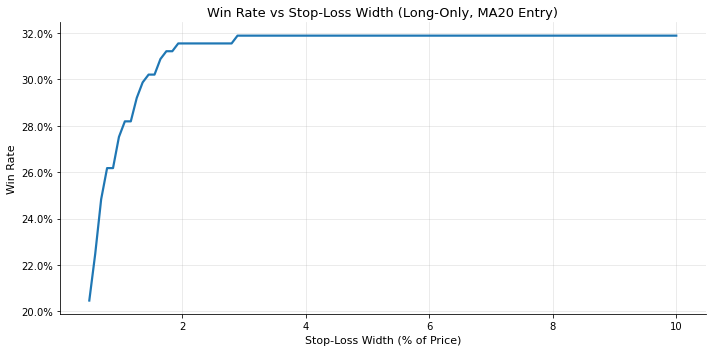

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

plt.rcParams.update({
    "figure.figsize": (10, 5),
    "axes.grid": True,
    "grid.alpha": 0.3,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "lines.linewidth": 2.2,
})


fig, ax = plt.subplots()

ax.plot(
    x * 100,
    res_df["win_rate"].values,
    color="#1f77b4"
)

ax.set_xlabel("Stop-Loss Width (% of Price)")
ax.set_ylabel("Win Rate")
ax.set_title("Win Rate vs Stop-Loss Width (Long-Only, MA20 Entry)")

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.tight_layout()
plt.savefig("fig1_winrate.png", dpi=300)
plt.show()


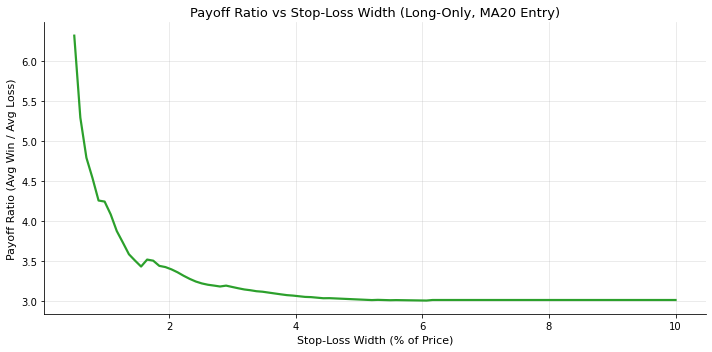

In [8]:
fig, ax = plt.subplots()

ax.plot(
    x * 100,
    res_df["payoff"].values,
    color="#2ca02c"
)

ax.set_xlabel("Stop-Loss Width (% of Price)")
ax.set_ylabel("Payoff Ratio (Avg Win / Avg Loss)")
ax.set_title("Payoff Ratio vs Stop-Loss Width (Long-Only, MA20 Entry)")

plt.tight_layout()
plt.savefig("fig2_payoff.png", dpi=300)
plt.show()


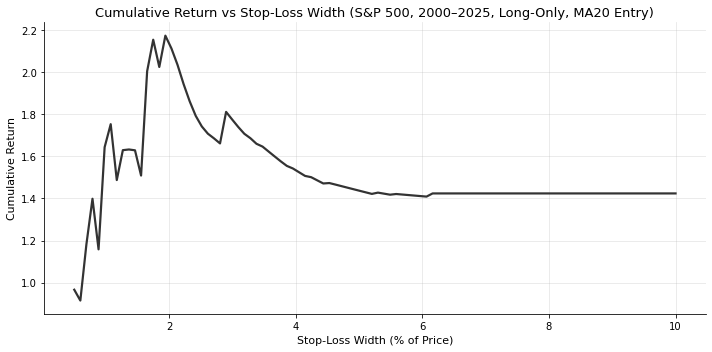

In [9]:
fig, ax = plt.subplots()

ax.plot(
    x * 100,
    res_df["cum_return"].values,
    color="#333333"
)

ax.set_xlabel("Stop-Loss Width (% of Price)")
ax.set_ylabel("Cumulative Return")
ax.set_title("Cumulative Return vs Stop-Loss Width (S&P 500, 2000–2025, Long-Only, MA20 Entry)")

plt.tight_layout()
plt.savefig("fig3_cumreturn.png", dpi=300)
plt.show()


In [10]:
df

,Unnamed: 0,DateTime,SPXopen,SPXhigh,SPXlow,SPXclose,VIX,SPXPnL,SPX_cumuPnL,MA20,entry_signal,exit_signal
0,2319,2000-02-14,1387.119995,1394.930054,1380.530029,1389.939941,24.379999,0.002031,3.254466,1421.700330,0,0
1,2320,2000-02-15,1389.939941,1407.719971,1376.250000,1402.050049,22.920000,0.008675,3.291534,1419.927999,0,1
2,2321,2000-02-16,1402.050049,1404.550049,1385.579956,1387.670044,23.510000,-0.010309,3.247518,1419.536332,0,1
3,2322,2000-02-17,1387.670044,1399.880005,1380.069946,1388.260010,23.170000,0.000425,3.249324,1419.074666,0,1
4,2323,2000-02-18,1388.260010,1388.589966,1345.319946,1346.089966,26.000000,-0.030847,3.120245,1417.162667,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6490,8809,2025-12-03,6815.290039,6862.419922,6810.430176,6849.720215,16.080000,0.005039,9.207114,6770.575326,0,0
6491,8810,2025-12-04,6866.470215,6866.470215,6827.120117,6857.120117,15.780000,-0.001363,9.193214,6775.832666,0,0
6492,8811,2025-12-05,6866.319824,6895.779785,6858.290039,6870.399902,15.410000,0.000594,9.199271,6780.231331,0,0
6493,8812,2025-12-08,6875.200195,6878.270020,6827.189941,6846.509766,16.660000,-0.004182,9.156710,6782.058659,0,0
